**Library**

In [ ]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import re
import numpy as np
!pip install transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.9 MB/s eta 0:00:00


**Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/Colab\ Notebooks/!Materi\ JDD\ 2024/deep_learning

/content/gdrive/MyDrive/Colab Notebooks/!Materi JDD 2024/deep_learning


In [ ]:
data = pd.read_csv('data.csv')
data.head()

,komentar,label
0,<username> Simulasi indonesia kembali dijajah ...,negatif
1,<username> <username> <username> keturunan lai...,negatif
2,<username> <username> uda botak keturunan penj...,negatif
3,"<username> <username> <username> Belum tentu, ...",negatif
4,<username> <username> <username> Lu nya aja yg...,negatif


**Exploratory Data Analysis (EDA)**



> Informasi Umum



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  398 non-null    object
 1   label     398 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB




> Missing Value



In [ ]:
print("missing_values :")
data.isnull().sum()

missing_values :


,0
komentar,0
label,0




> Shape



In [ ]:
data.shape

(398, 2)



> Distribusi Panjang Text



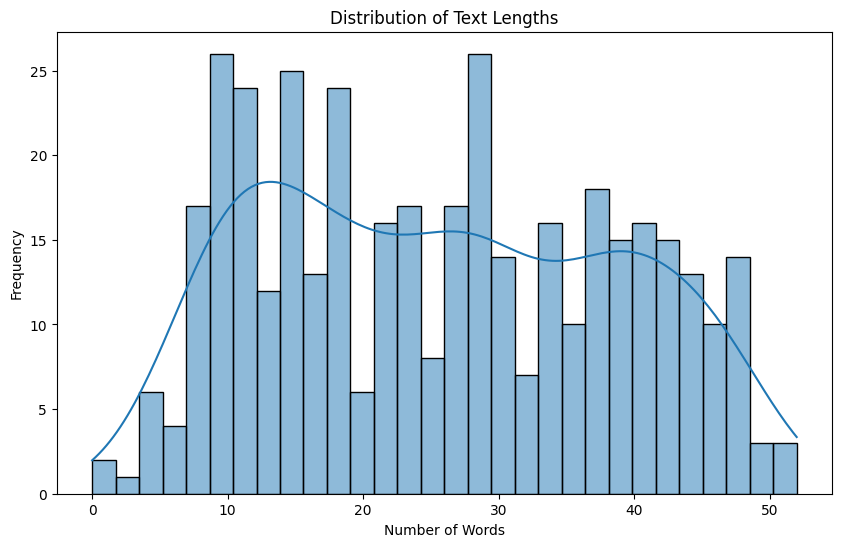

In [ ]:
data['text_length'] = data['komentar'].apply(lambda x: len(x.split()))

avg_text_length = data['text_length'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

**Preprocessing**



> Inisialisasi



In [ ]:
nltk.download('punkt')
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.




> Fungsi



In [ ]:
def preprocess_text(text):
    # Convert ke lowercase
    text = text.lower()
    # Hapus <username>
    text = re.sub(r'<username>', '', text)
    # Hapus <username>
    text = re.sub(r'<\w+\s*>', '', text)
    # Hapus URL
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    # Menghapus tanda pagar
    text = re.sub(r'#\w+\s*', '', text)
    # Menghapus mention
    text = re.sub(r'@\w+\s*', '', text)
    # Hapus Tanda Baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Hapus Angka
    text = re.sub(r'\d+', '', text)
    # Hapus Stopwords
    text = stopword_remover.remove(text)
    # Stemming
    # text = stemmer.stem(text)
    # Hapus spasi berlebih dan baris baru
    text = ' '.join(text.split())
    return text



> Apply Fungsi



In [ ]:
data['text_clean'] = data['komentar'].apply(preprocess_text)
data

,komentar,label,text_length,text_clean
0,<username> Simulasi indonesia kembali dijajah ...,negatif,28,simulasi indonesia dijajah keturunan belanda k...
1,<username> <username> <username> keturunan lai...,negatif,30,keturunan yang gak main bola emang di naturali...
2,<username> <username> uda botak keturunan penj...,negatif,23,uda botak keturunan penjajah sok si paling pah...
3,"<username> <username> <username> Belum tentu, ...",negatif,38,gak semuanya jadi pemain bola yg milih karir p...
4,<username> <username> <username> Lu nya aja yg...,negatif,27,lu nya aja yg bego makanya nonton sendiri tolo...
...,...,...,...,...
393,<username> <username> 3 tahun lalu indonesia m...,positif,19,tahun lalu indonesia memang ga gencar buat nat...
394,\,positif,1,
395,Naturalisasi pemain keturunan menjadi langkah ...,positif,35,naturalisasi pemain keturunan menjadi langkah ...
396,semua persyaratan yang diperlukan untuk proses...,positif,25,semua persyaratan diperlukan proses naturalisa...




> Pilah dan Buat dataframe baru



In [ ]:
df = data[['label', 'text_clean']]
df.head()

,label,text_clean
0,negatif,simulasi indonesia dijajah keturunan belanda k...
1,negatif,keturunan yang gak main bola emang di naturali...
2,negatif,uda botak keturunan penjajah sok si paling pah...
3,negatif,gak semuanya jadi pemain bola yg milih karir p...
4,negatif,lu nya aja yg bego makanya nonton sendiri tolo...


In [ ]:
df.to_csv('Dataset Bersih.csv', index=False)

df

,label,text_clean
0,negatif,simulasi indonesia dijajah keturunan belanda k...
1,negatif,keturunan yang gak main bola emang di naturali...
2,negatif,uda botak keturunan penjajah sok si paling pah...
3,negatif,gak semuanya jadi pemain bola yg milih karir p...
4,negatif,lu nya aja yg bego makanya nonton sendiri tolo...
...,...,...
393,positif,tahun lalu indonesia memang ga gencar buat nat...
394,positif,
395,positif,naturalisasi pemain keturunan menjadi langkah ...
396,positif,semua persyaratan diperlukan proses naturalisa...


In [ ]:
labelcount = df['label'].value_counts()
labelcount

,count
label,
positif,204
negatif,194


**Transformation**



> TF-IDF



In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['text_clean']).toarray()



> Label Encoding



In [ ]:
label_mapping = {'negatif': 0, 'positif': 1}
y = df['label'].map(label_mapping).values

**Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



> Bentuk data untuk Bi-LSTM



In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

**Pemodelan (Bi-LSTM)**



> *Inisialisasi Model*



In [ ]:
model = Sequential()
model.add(Input(shape=(1, X_train.shape[2])))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])



> *Latih Model*



In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.4809 - loss: 0.6930 - val_accuracy: 0.4688 - val_loss: 0.6933
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5203 - loss: 0.6903 - val_accuracy: 0.4688 - val_loss: 0.6932
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5437 - loss: 0.6841 - val_accuracy: 0.4688 - val_loss: 0.6928
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5366 - loss: 0.6727 - val_accuracy: 0.4688 - val_loss: 0.6918
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6134 - loss: 0.6422 - val_accuracy: 0.4844 - val_loss: 0.6904
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6653 - loss: 0.6088 - val_accuracy: 0.5000 - val_loss: 0.6852
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8489 - loss: 0.5415 - val_accuracy: 0.5469 - val_loss: 0.6800
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9384 - loss: 0.4569 - val_accuracy: 0.6094 - val_loss: 0.6704



> *Prediksi*



In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step




> *Evaluasi*



In [ ]:
class_report = classification_report(y_test, y_pred, target_names=label_mapping.keys())
print('Classification Report with Bi-LSTM:\n', class_report)

Classification Report with Bi-LSTM:
               precision    recall  f1-score   support

     negatif       0.89      0.57      0.69        44
     positif       0.63      0.92      0.75        36

    accuracy                           0.72        80
   macro avg       0.76      0.74      0.72        80
weighted avg       0.78      0.72      0.72        80





> *Confusion Matrix*




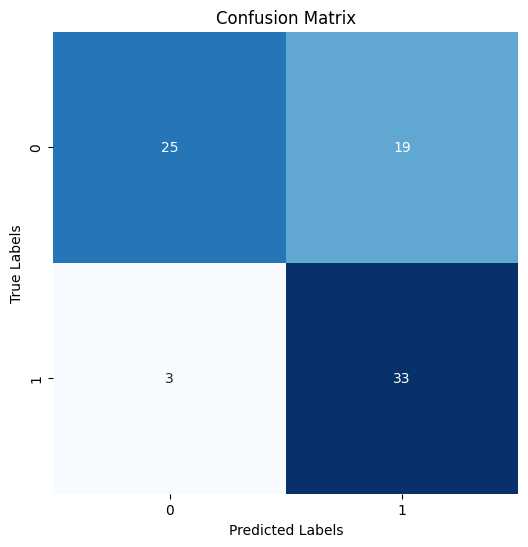

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()